<a href="https://colab.research.google.com/github/jarkrandel/mnist-classifiers/blob/main/minst_simple_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Simple linear classifier should achieve at least ~85% accuracy? Let's see.
# Processing
with open('drive/MyDrive/data/train-images.idx3-ubyte', mode='rb') as file:
    train_images_file = file.read()
with open('drive/MyDrive/data/train-labels.idx1-ubyte', mode='rb') as file:
    train_labels_file = file.read()
with open('drive/MyDrive/data/t10k-images.idx3-ubyte', mode='rb') as file:
    test_images_file = file.read()
with open('drive/MyDrive/data/t10k-labels.idx1-ubyte', mode='rb') as file:
    test_labels_file = file.read()

train_images_file = train_images_file[16:]
train_labels_file = train_labels_file[8:]
test_images_file = test_images_file[16:]
test_labels_file = test_labels_file[8:]

train_images = np.array(struct.unpack('47040000B', train_images_file)).reshape((60000,28,28))
train_labels = np.array(struct.unpack('60000B', train_labels_file))
test_images = np.array(struct.unpack('7840000B', test_images_file)).reshape((10000,28,28))
test_labels = np.array(struct.unpack('10000B', test_labels_file))

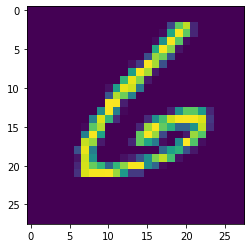

In [2]:
plt.imshow(train_images[-2])

In [3]:
# Train / val split
X_train = train_images[0:60000,:,:]
y_train = train_labels[0:60000]

X_val = train_images[54001:,:,:]
y_val = train_labels[54001:]

In [4]:
# Initialize weights and outputs (what scaling should be used as input to softmax, if any?)
W = np.random.normal(0, 1 / np.sqrt(784), (784, 10))
b = np.random.normal(0, 1, (1, 10)) * 0.01
A, Z = 0, 0

# Initialize gradients
dW = np.zeros((784, 10))
db = np.zeros((1,10))

In [5]:
# Forward/backward pass defs

# standard softmax def down rows
def softmax(A):
    S = np.exp(A)
    return S / np.sum(S, axis=1).reshape(S.shape[0], 1)

def oh(y, colnum):
    y_oh = np.zeros((y.size, colnum))
    y_oh[np.arange(y.size), y] = 1
    return y_oh

# Send a matrix of shape (batch_size, 784 pixels) into forward and receive a (batch_size, 10) vector
# containing classification probabilities computed using weights
def forward(X):
  # Z.shape == (batch_size, 10)
  Z = np.dot(X, W) + b
  A = softmax(Z)
  return A

# Given batch X:(batch_size, 10) and one hot encoding of targets y:(batch_size, 10), 
# compute cross entropy loss with current activations
def loss(X, y):
  batch_size = X.shape[0]
  return (1 / batch_size) * np.sum(-np.log(forward(X)) * y)

def accuracy(X, y):
  preds = np.argmax(forward(X), axis=1)
  preds = oh(preds, 10)
  return (1 / X.shape[0]) * np.sum(preds * y)

# Use the forward computations to update gradients via backprop
def backward(X, A, y):
  # dL/da_ij = -1/a_ij if j is correct class for i-th sample else 0 
  # technically not necessary to compute since dZ is easy
  # dA = -1 / (A * y)
  
  # dL/dz_ij = \sum_l,k dL/da_lk * da_lk/dz_ij = dL/da_i,y[i] * da_i,y[i]/dz_ij
  #          = a_ij - 1 if j is correct class else a_ij
  dZ = (1 / X.shape[0]) * (A - y)

  # dL/dw_ij = \sum_l,k dL/dz_lk * dz_lk/dw_ij = dZ_lk * X_li * delta_jk
           # = dZ_lj * X_li = (X^T * dZ)_ij
  dW = np.dot(np.transpose(X), dZ)

  # dL/db_k = dL/dz_ij * dz_ij/db_k = each b contributes 1 to each Z in its column,
  # so sum 1s across rows
  db = np.sum(dZ, axis=0).reshape(1, -1)
  return dW, db

In [6]:
# set parameters and initialize containers
losses = []
val_losses = []
epoch_num = 10
mb_size = 60
mb_num = 60000 // mb_size

# implement Adam optimization
lr = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# normalize images and change labels to one hot encoding
X = ((X_train - 128) / 256).reshape(-1, 28*28)
X_val = ((X_val - 128) / 256).reshape(-1, 28*28)
X_test = ((test_images - 128) / 256).reshape(-1, 28*28)

y = oh(y_train, 10)
y_val = oh(y_val, 10)
y_test = oh(test_labels, 10)

In [7]:
# initialize first moment and second moment moving averages
t = 1
dWm_t = np.zeros(W.shape)
dWv_t = np.zeros(W.shape)
dbm_t = np.zeros(b.shape)
dbv_t = np.zeros(b.shape)

# train
for epoch in range(epoch_num):
  # shuffle data
  X, y = shuffle(X, y)

  for i in range(mb_num):
    X_mb = X[i*mb_size:(i+1)*mb_size,:]
    y_mb = y[i*mb_size:(i+1)*mb_size]

    # make a forward pass with mini batch
    A = forward(X_mb)
    
    # record loss every now and then
    if i % 100 == 0:
      losses.append(loss(X_mb, y_mb))
      val_losses.append(loss(X_val, y_val))
    
    # compute gradients from mini batch and update moving averages
    # TODO: replace copied code with for loop over parameters
    dW, db = backward(X_mb, A, y_mb)
    # first moment
    dWm_t = (1-beta1)*dWm_t + beta1*dW
    dbm_t = (1-beta1)*dbm_t + beta1*db
    # second moment
    dWv_t = (1-beta2)*dWv_t + beta2*dW*dW
    dbv_t = (1-beta2)*dbv_t + beta2*db*db
    # normalize
    dWm_t = dWm_t / (1 - beta1**t)
    dbm_t = dbm_t / (1 - beta1**t)
    dWv_t = dWv_t / (1 - beta2**t)
    dbv_t = dbv_t / (1 - beta2**t)
    # adjust weights with gradients
    W -= lr * dWm_t / (np.sqrt(dWv_t) + epsilon)
    b -= lr * dbm_t / (np.sqrt(dbv_t) + epsilon)
    t += 1

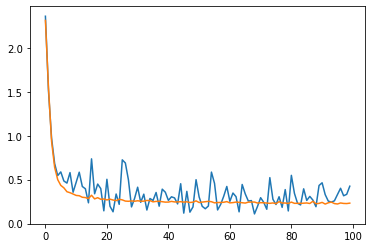

In [8]:
plt.plot(losses)
plt.plot(val_losses)
plt.show()

In [9]:
val_losses[-10:]

[0.24097208138300738,
 0.2218678401283754,
 0.23626855319315632,
 0.24444917532438973,
 0.22748122395974632,
 0.22274052788644677,
 0.2342830476758674,
 0.2289345557619417,
 0.22761109929032247,
 0.23230594334922358]

In [10]:
accuracy(X_test, y_test)

0.9144

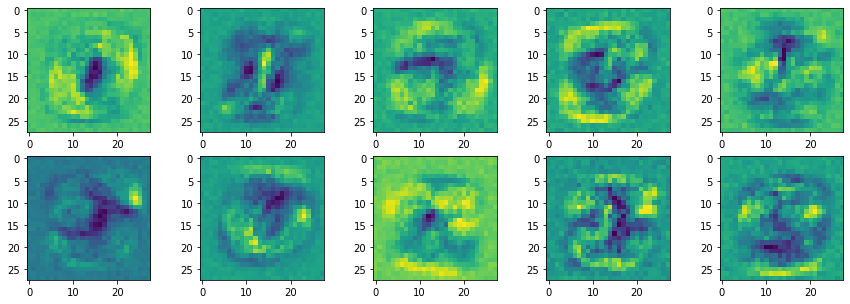

In [11]:
# Visualize weights for each digit at each pixel location
Wmaps = W.reshape(28,28,10)
fig, ax = plt.subplots(2, 5, figsize=(15,5))
for i in range(2):
  for j in range(5):
    ax[i,j].imshow(Wmaps[:,:, i*5 + j])
plt.show()